In [2]:
import sys
sys.path.append("/volatile/aurelien_stumpf_mascles/project/code")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R

In [21]:
import importlib
importlib.reload(package.preprocessing)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/dataset.py'>

## Utilitaires

In [2]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(model, dataset):
    return get_emissions(model, dataset)

## DBS

In [13]:
cd /neurospin/lbi/monkeyfmri/deepstim/database/DBS_database/rawdata/dfc/outliers

/neurospin/lbi/monkeyfmri/deepstim/database/DBS_database/rawdata/dfc/outliers


In [14]:
ls

dfc.npy*  metadata.tsv*


## Data Loading

In [4]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/DBS_database/rawdata/dfc/outliers/dfc.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/DBS_database/rawdata/dfc/outliers/metadata.tsv", sep="\t")

In [5]:
n_runs = len(set(meta["unique_id"] + meta["monkey"]))
n_wins = 464
dfc_all = dfc.reshape((-1, n_wins, 82, 82))

In [10]:
def STRUCTURE(x,y):
        return 1 - package.preprocessing.structure(x,y,is_batch = False)

metric = STRUCTURE

In [5]:
dict_labels = {'awake-bold' : 0, 'stim-cont-on-3v' : 1, 'stim-cont-on-5v' : 2, 'stim-off' : 3, 'stim-on-3v' : 4, 'stim-on-5v' : 5}

In [6]:
meta_condition = meta["condition"]
labels_all_condition = np.array([meta_condition.iloc[i] for i in range(len(meta_condition))])
labels_all = np.array([dict_labels[elem] for elem in labels_all_condition]).reshape((len(labels_all_condition)//464,464))

In [10]:
fc_dbs = dfc_all.reshape((dfc_all.shape[0],464,1,82,82))

## Cebra

In [35]:
fc_dbs = dfc_all.reshape((dfc_all.shape[0],464,82,82))
fc_dbs_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(fc_dbs)))
fc_dbs_vector = fc_dbs_vector.type(torch.float32)

In [29]:
num_output = 3
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        100,
    ),
    nn.Dropout(0.2),
    nn.GELU(),
    nn.Linear(
        100,
        20,
    ),
    nn.GELU(),
    nn.Linear(
        20,
        3,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )
model.load_state_dict(torch.load('/volatile/aurelien_stumpf_mascles/project/models/model.pth'))
model.eval()

Model(
  (net): Sequential(
    (0): Linear(in_features=3321, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): GELU(approximate='none')
    (3): Linear(in_features=100, out_features=20, bias=True)
    (4): GELU(approximate='none')
    (5): Linear(in_features=20, out_features=3, bias=True)
    (6): _Norm()
    (7): Squeeze()
  )
)

In [41]:
labels_all.shape

(184, 464)

In [36]:
fc_dbs_vector.shape

torch.Size([184, 464, 3321])

In [89]:
np.argwhere(labels_all[:,0] == 5)

array([[108],
       [109],
       [110],
       [111],
       [112],
       [113],
       [114],
       [115],
       [116],
       [117],
       [118],
       [119],
       [120],
       [121],
       [122],
       [123],
       [124],
       [125],
       [126],
       [127],
       [128],
       [129],
       [130],
       [131],
       [132],
       [133],
       [134],
       [135],
       [136],
       [137],
       [138],
       [139],
       [140],
       [141],
       [142],
       [143]])

/tmp/ipykernel_662/2622663001.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[:,1], fc_emb[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_all[i,0]], s=1)


(-1.0996078163385392,
 1.0996096640825272,
 -1.0999904900789261,
 1.0999681383371354)

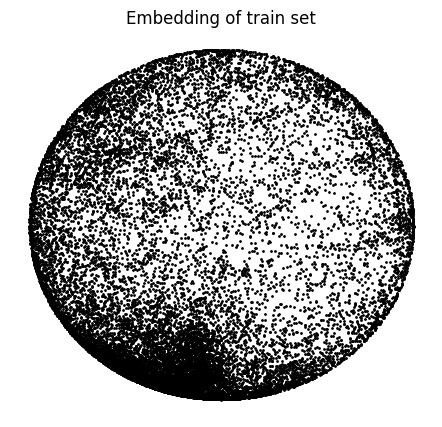

In [65]:
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding of train set')
colors = ["black",'red','green',"blue","pink","yellow"]
for i in range(40):
    fc_emb = _compute_emissions_single(model, fc_dbs_vector[i,:,:])
    ax1.scatter(fc_emb[:,1], fc_emb[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_all[i,0]], s=1)
#ax1.xticks() 
ax1.axis('off')

### Algorithme de classification

In [73]:
labels_all.shape

(184, 464)

In [67]:
net = package.torch_classifier.MLP(input_dim = 3,output_dim = 3)
net.load_state_dict(torch.load('/volatile/aurelien_stumpf_mascles/project/models/classifier.pth'))

<All keys matched successfully>

In [74]:
net.eval()
for session in range(184):
    fc_emb = torch.from_numpy(_compute_emissions_single(model, fc_dbs_vector[session,:,:]))
    probas = torch.sum(torch.exp(net(fc_emb.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    print("True label : {}, Predicted label : {}, Probas : {}".format(labels_all[session,0],res,probas.detach().numpy()))

True label : 0, Predicted label : 2, Probas : [0.19216716 0.11656231 0.6912705 ]
True label : 0, Predicted label : 2, Probas : [0.11048429 0.06250868 0.82700706]
True label : 0, Predicted label : 2, Probas : [0.25909987 0.1812598  0.5596403 ]
True label : 0, Predicted label : 2, Probas : [0.3035058  0.26910603 0.4273882 ]
True label : 0, Predicted label : 2, Probas : [0.1528837  0.11042586 0.7366904 ]
True label : 0, Predicted label : 2, Probas : [0.27372438 0.22274707 0.50352854]
True label : 0, Predicted label : 2, Probas : [0.27238435 0.25117823 0.47643745]
True label : 0, Predicted label : 2, Probas : [0.10251262 0.08483481 0.8126526 ]
True label : 0, Predicted label : 1, Probas : [0.35342145 0.41255444 0.23402411]
True label : 0, Predicted label : 2, Probas : [0.22361274 0.13958111 0.6368061 ]
True label : 0, Predicted label : 1, Probas : [0.3856672  0.39450812 0.2198247 ]
True label : 0, Predicted label : 2, Probas : [0.20616588 0.13299617 0.66083795]
True label : 0, Predicted la

In [91]:
net.eval()
accu = torch.zeros(3)
print("[light-propofol,deep-propofol,awake]")
for session in range(0,41):
    fc_emb = torch.from_numpy(_compute_emissions_single(model, fc_dbs_vector[session,:,:]))
    probas = torch.sum(torch.exp(net(fc_emb.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("awake-bold :",accu/41)

accu = torch.zeros(3)
for session in range(144,164):
    fc_emb = torch.from_numpy(_compute_emissions_single(model, fc_dbs_vector[session,:,:]))
    probas = torch.sum(torch.exp(net(fc_emb.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-cont-on-3v :",accu/20)

accu = torch.zeros(3)
for session in range(164,184):
    fc_emb = torch.from_numpy(_compute_emissions_single(model, fc_dbs_vector[session,:,:]))
    probas = torch.sum(torch.exp(net(fc_emb.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-cont-on-5v :",accu/20)

accu = torch.zeros(3)
for session in range(41,73):
    fc_emb = torch.from_numpy(_compute_emissions_single(model, fc_dbs_vector[session,:,:]))
    probas = torch.sum(torch.exp(net(fc_emb.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-off :",accu/32)

accu = torch.zeros(3)
for session in range(73,108):
    fc_emb = torch.from_numpy(_compute_emissions_single(model, fc_dbs_vector[session,:,:]))
    probas = torch.sum(torch.exp(net(fc_emb.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-on-3v :",accu/34)

accu = torch.zeros(3)
for session in range(108,144):
    fc_emb = torch.from_numpy(_compute_emissions_single(model, fc_dbs_vector[session,:,:]))
    probas = torch.sum(torch.exp(net(fc_emb.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-on-5v :",accu/35)

[light-propofol,deep-propofol,awake]
awake-bold : tensor([0.2195, 0.0732, 0.7073])
stim-cont-on-3v : tensor([0.3000, 0.0000, 0.7000])
stim-cont-on-5v : tensor([0.7500, 0.0000, 0.2500])
stim-off : tensor([0.8125, 0.0000, 0.1875])
stim-on-3v : tensor([0.4118, 0.1471, 0.4706])
stim-on-5v : tensor([0.2286, 0.0000, 0.8000])


## MLP on dbs

In [94]:
mlp = package.torch_classifier.MLP2(input_dim = 3321,output_dim = 3)
mlp.load_state_dict(torch.load('/volatile/aurelien_stumpf_mascles/project/models/condition_classifier.pth'))

<All keys matched successfully>

In [97]:
mlp.eval()
for session in range(184):
    probas = torch.sum(torch.exp(mlp(fc_dbs_vector[session,:,:].type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    print("True label : {}, Predicted label : {}, Probas : {}".format(labels_all[session,0],res,probas.detach().numpy()))

True label : 0, Predicted label : 0, Probas : [0.8057636  0.06592146 0.128315  ]
True label : 0, Predicted label : 0, Probas : [0.77404153 0.03551681 0.19044167]
True label : 0, Predicted label : 0, Probas : [0.57464415 0.21402368 0.21133216]
True label : 0, Predicted label : 0, Probas : [0.69819415 0.11385728 0.18794858]
True label : 0, Predicted label : 0, Probas : [7.0508933e-01 2.4787523e-05 2.9488596e-01]
True label : 0, Predicted label : 0, Probas : [0.69860876 0.10491075 0.1964805 ]
True label : 0, Predicted label : 0, Probas : [0.5999804  0.06472281 0.33529684]
True label : 0, Predicted label : 0, Probas : [0.5690403  0.07093722 0.36002246]
True label : 0, Predicted label : 0, Probas : [0.48737684 0.074703   0.43792012]
True label : 0, Predicted label : 0, Probas : [0.75449413 0.05296081 0.19254507]
True label : 0, Predicted label : 0, Probas : [0.79273754 0.13546167 0.07180074]
True label : 0, Predicted label : 0, Probas : [0.50913703 0.16848831 0.32237464]
True label : 0, Pre

In [100]:
mlp.eval()
accu = torch.zeros(3)
print("[light-propofol,deep-propofol,awake]")
for session in range(0,41):
    probas = torch.sum(torch.exp(mlp(fc_dbs_vector[session,:,:].type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("awake-bold :",accu/41)

accu = torch.zeros(3)
for session in range(144,164):
    probas = torch.sum(torch.exp(mlp(fc_dbs_vector[session,:,:].type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-cont-on-3v :",accu/20)

accu = torch.zeros(3)
for session in range(164,184):
    probas = torch.sum(torch.exp(mlp(fc_dbs_vector[session,:,:].type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-cont-on-5v :",accu/20)

accu = torch.zeros(3)
for session in range(41,73):
    probas = torch.sum(torch.exp(mlp(fc_dbs_vector[session,:,:].type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-off :",accu/32)

accu = torch.zeros(3)
for session in range(73,108):
    probas = torch.sum(torch.exp(mlp(fc_dbs_vector[session,:,:].type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-on-3v :",accu/34)

accu = torch.zeros(3)
for session in range(108,144):
    probas = torch.sum(torch.exp(mlp(fc_dbs_vector[session,:,:].type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-on-5v :",accu/36)

[light-propofol,deep-propofol,awake]
awake-bold : tensor([0.7073, 0.0244, 0.2683])
stim-cont-on-3v : tensor([0.9500, 0.0000, 0.0500])
stim-cont-on-5v : tensor([1., 0., 0.])
stim-off : tensor([0.9375, 0.0000, 0.0625])
stim-on-3v : tensor([0.7941, 0.0882, 0.1471])
stim-on-5v : tensor([1., 0., 0.])


## CNN on DBS

In [8]:
net = package.torch_classifier.CNN1()
net.load_state_dict(torch.load('/volatile/aurelien_stumpf_mascles/project/models/model_cnn.pth'))

<All keys matched successfully>

In [11]:
fc_dbs.shape

(184, 464, 1, 82, 82)

In [13]:
net.eval()
for session in range(184):
    data = torch.from_numpy(fc_dbs[session,:,:,:,:])
    probas = torch.sum(torch.exp(net(data.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    print("True label : {}, Predicted label : {}, Probas : {}".format(labels_all[session,0],res,probas.detach().numpy()))

True label : 0, Predicted label : 2, Probas : [0.28819072 0.08055402 0.63125527]
True label : 0, Predicted label : 0, Probas : [0.5199622  0.00705039 0.4729874 ]
True label : 0, Predicted label : 0, Probas : [0.5244122  0.09389003 0.38169777]
True label : 0, Predicted label : 0, Probas : [0.5052182  0.13198529 0.3627965 ]
True label : 0, Predicted label : 0, Probas : [0.5095263  0.01120934 0.47926432]
True label : 0, Predicted label : 0, Probas : [0.5660614  0.03353008 0.40040854]
True label : 0, Predicted label : 2, Probas : [0.38502738 0.03354507 0.58142745]
True label : 0, Predicted label : 2, Probas : [0.42563492 0.07127184 0.50309324]
True label : 0, Predicted label : 0, Probas : [0.4629062  0.07985499 0.4572388 ]
True label : 0, Predicted label : 0, Probas : [0.5784206  0.15610833 0.26547107]
True label : 0, Predicted label : 1, Probas : [0.3290021  0.50146854 0.1695293 ]
True label : 0, Predicted label : 2, Probas : [0.33660686 0.04886746 0.6145257 ]
True label : 0, Predicted la

In [15]:
net.eval()
accu = torch.zeros(3)
print("[light-propofol,deep-propofol,awake]")
for session in range(0,41):
    data = torch.from_numpy(fc_dbs[session,:,:,:,:])
    probas = torch.sum(torch.exp(net(data.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("awake-bold :",accu/41)

accu = torch.zeros(3)
for session in range(144,164):
    data = torch.from_numpy(fc_dbs[session,:,:,:,:])
    probas = torch.sum(torch.exp(net(data.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-cont-on-3v :",accu/20)

accu = torch.zeros(3)
for session in range(164,184):
    data = torch.from_numpy(fc_dbs[session,:,:,:,:])
    probas = torch.sum(torch.exp(net(data.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-cont-on-5v :",accu/20)

accu = torch.zeros(3)
for session in range(41,73):
    data = torch.from_numpy(fc_dbs[session,:,:,:,:])
    probas = torch.sum(torch.exp(net(data.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-off :",accu/32)

accu = torch.zeros(3)
for session in range(73,108):
    data = torch.from_numpy(fc_dbs[session,:,:,:,:])
    probas = torch.sum(torch.exp(net(data.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-on-3v :",accu/34)

accu = torch.zeros(3)
for session in range(108,144):
    data = torch.from_numpy(fc_dbs[session,:,:,:,:])
    probas = torch.sum(torch.exp(net(data.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    accu[res] += 1
print("stim-on-5v :",accu/36)

[light-propofol,deep-propofol,awake]
awake-bold : tensor([0.4634, 0.0244, 0.5122])
stim-cont-on-3v : tensor([0.2500, 0.2000, 0.5500])
stim-cont-on-5v : tensor([0.6500, 0.2500, 0.1000])
stim-off : tensor([0.5000, 0.3438, 0.1562])
stim-on-3v : tensor([0.5000, 0.1176, 0.4118])
stim-on-5v : tensor([0.1944, 0.1111, 0.6944])
